In [1]:
# %matplotlib notebook

from matplotlib import pylab
from astropy.coordinates import SkyCoord
import integralclient as ic

import time
import numpy as np

from astropy.table import Table, vstack
from astropy.io import fits
import glob
from scipy import stats
from astropy.time import Time

failed to get AUTH with env due to: 'K8S_SECRET_INTEGRAL_CLIENT_SECRET'
got AUTH with homefile for integral-limited


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
RA=293.732
Dec=21.8967222
tstart_rel_mseconds=300.0
tstop_rel_seconds=300.0
t0_utc="2023-05-24T20:22:41.837" 
# t0_utc=Time(Time("2022-10-14T19:21:47").mjd - 8.632259375000002/24/3600, format='mjd').isot.replace(" ", "T") # hard x-ray
# t0_utc="2022-10-14T19:21:47"
# rt=1
# nrt=1
# arc=0
required_completeness=0.6
mode="rt" # scw|rt|arc
# mode="scw" # scw|rt|arc
global_snr_threshold=3.
negative_excesses=0

In [3]:
t0_utc

'2023-05-24T20:22:41.837'

In [4]:
if mode == "scw":
    rt=0
    nrt=1
    arc=0
elif mode == "rt":
    rt=1
    nrt=0
    arc=0
elif mode == "arc":
    rt=0
    nrt=0
    arc=1
elif mode == "flags":
    print("mode set by flags")
else:
    raise Exception("unknown mode: {}, allowed: scw, rt".format(mode))

In [5]:
source_coord = SkyCoord(RA, Dec, unit = "deg")

In [6]:
import importlib

In [7]:
# /home/savchenk/work/transients/workflows/integral-all-sky

import integralenv
importlib.reload(integralenv)

arc_root_prefix = integralenv.get_arc_root_prefix()

In [8]:
now_ijd = float(ic.converttime("UTC",time.strftime("%Y-%m-%dT%H:%M:%S"),"IJD"))
t0_ijd =  float(ic.converttime("UTC",t0_utc,"IJD"))

tstart_ijd = t0_ijd - tstart_rel_mseconds/24./3600
tstop_ijd = t0_ijd + tstop_rel_seconds/24./3600

now_ijd, t0_ijd, tstart_ijd, tstop_ijd

2023-05-24 22:33:53 savchenk-NG-VN7-793G-79EG root[2852396] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/UTC/2023-05-24T22:33:53/IJD
2023-05-24 22:33:54 savchenk-NG-VN7-793G-79EG root[2852396] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/UTC/2023-05-24T20:22:41.837/IJD


(8544.9409975, 8544.849896076388, 8544.846423854166, 8544.85336829861)

In [9]:
lcs={}


In [10]:
if nrt == 1:
    import isdcclient

    IC = isdcclient.ISDCClient()

    
    lcs['ACS'] = IC.genlc("ACS", t0_utc, "%.10lg"%max(tstart_rel_mseconds,tstop_rel_seconds),format='numpy')

    print("got lc from service of", lcs['ACS'])

    lcs['ACS'][:,1] = 0.05
    print("got ACS", lcs['ACS'])
    
    #lcs['IBIS/Veto'] = IC.genlc("IBIS_VETO", t0_utc, "%.10lg"%max(tstart_rel_mseconds,tstop_rel_seconds),format='numpy')
    #lcs['IBIS/Veto'][:,1] = 8.

import requests


if rt == 1:
    url = f"https://www.astro.unige.ch/mmoda/dispatch-data/gw/integralhk/api/v1.0/rtlc/{t0_utc}/{tstop_rel_seconds}?json&prophecy"
    print("url:", url)
    r = requests.get(url)
    lc = np.array(r.json()['lc']['data'])
    lcs['ACS'] = np.vstack([lc[:,1], lc[:,1] * 0 + 0.05, lc[:,0]]).T

url: https://www.astro.unige.ch/mmoda/dispatch-data/gw/integralhk/api/v1.0/rtlc/2023-05-24T20:22:41.837/300.0?json&prophecy


In [11]:
r.content

b'{"lc":{"column_names":[null],"columns":["counts","ijd"],"data":[[4384,8544.846424201389],[4536,8544.846424780093],[4378,8544.846425358797],[4448,8544.8464259375],[4384,8544.846426516204],[4430,8544.846427094908],[4488,8544.84642767361],[4420,8544.846428252313],[4420,8544.846428831017],[4376,8544.846429409723],[4396,8544.846429988425],[4414,8544.84643056713],[4448,8544.846431145834],[4370,8544.846431724536],[4380,8544.84643230324],[4372,8544.846432881945],[4414,8544.846433460649],[4306,8544.846434039351],[4406,8544.846434618054],[4560,8544.846435196758],[4582,8544.846435775462],[4368,8544.846436354166],[4428,8544.84643693287],[4344,8544.846437511575],[4506,8544.846438090277],[4472,8544.846438668981],[4494,8544.846439247685],[4386,8544.84643982639],[4322,8544.846440405092],[4428,8544.846440983794],[4408,8544.846441562499],[4382,8544.846442141203],[4586,8544.846442719907],[4362,8544.846443298611],[4464,8544.846443877315],[4504,8544.846444456018],[4550,8544.846445034724],[4298,8544.84644

(-5.0, 5.0)

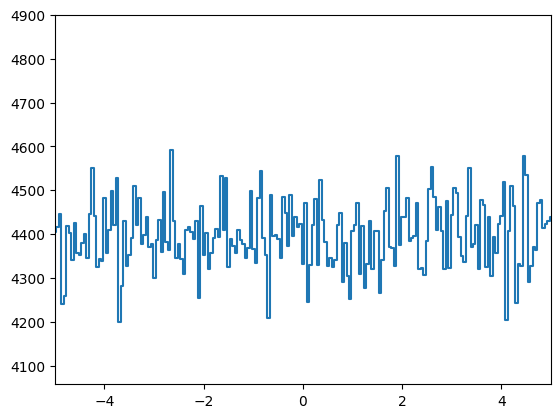

In [12]:
from matplotlib import pylab as plt

plt.figure()

plt.step(
    (lcs['ACS'][:,0] - t0_ijd)*24*3600,
    lcs['ACS'][:,2],
)

plt.xlim(-5,5)

In [13]:
def rebin(lc,n,av = False):
    if n == 0: return lc
    
    N=int(lc.shape[0]/n)*n
    if av:
        return lc[:N].reshape((int(lc.shape[0]/n), n)).mean(1)
    else:
        return lc[:N].reshape((int(lc.shape[0]/n), n)).sum(1)

In [14]:
import re
import time

# if rt == 1:

#     got_data = False
    
#     while not got_data:
#         current_rev=float(ic.converttime("UTC",t0_utc,"REVNUM"))

#         print("current rev", current_rev)

#         rtdata_roots=[
#             '/unsaved/astro/savchenk/dockers/realtimeacs/docker-ibas/spiacs-lcdump',
#             '/rtdata',
#             '/mnt/sshfs/isdc-in01//unsaved/astro/savchenk/dockers/realtimeacs/docker-ibas/spiacs-lcdump',    
#         ]

#         for realtime_dump_root in rtdata_roots + [ None ]:
#             #print("probing",realtime_dump_root,"with",glob.glob(realtime_dump_root+"/lcdump-revol-*.csv"))
#             if realtime_dump_root and len(glob.glob(realtime_dump_root+"/lcdump-revol-*.csv"))>0:
#                 print("this",realtime_dump_root)
#                 break

#         if not realtime_dump_root:
#             raise Exception("no realtime archvie found")

#         for rt_fn in reversed(sorted([l for l in glob.glob(realtime_dump_root+"/lcdump-revol-*.csv") if 
#                        float(re.search("lcdump-revol-(\d{4}).*.csv",l).groups()[0])<=current_rev+1])):

#             print(rt_fn)

#             rt_lc = np.genfromtxt(rt_fn)

#             lcs['ACS']=rt_lc[:,(3,0,2,0)]
#             lcs['ACS'][:,1] = 0.05

#             first_data = lcs['ACS'][:,0][0]
#             last_data = lcs['ACS'][:,0][-1]

#             print("now", now_ijd, 
#                   "first data in file", first_data, 
#                   "last data", last_data, 
#                   "requested", t0_ijd, 
#                   "have margin", (last_data-t0_ijd)*24*3600,"s",
#                   "data delay", (now_ijd-last_data)*24*3600,"s")       


#             if t0_ijd<first_data:
#                 print("data in the previous file")
#                 continue
                

#             print("margin",(last_data-now_ijd)*24*3600-tstop_rel_seconds*1.5 + 100)
#             if  (last_data-t0_ijd)*24*3600>tstop_rel_seconds*1.5 + 100:                            
#                 print("this margin is sufficient")
#                 got_data=True
#                 break
#             else:
#                 print("this margin is NOT sufficient, waiting")
#             #    if (now_ijd-last_data)*24*3600>1000:
#             #        raise RuntimeError('margin insufficent, data too old: no more hope')                

#                 time.sleep(30)
#                 break
        
            
            

    

In [15]:
# lcs['ACS']

lcs['ACS'][:,0].min()

8544.846424201389

total lc (12000, 3)
min -0.003471874999377178
max 0.0034719953710009577
expected telapse 600.0 telapse 599.9504000006709 ontime 600.0000000000001
size (12000, 3) (12000,)
requested scale 0.05
b_tb 0.05000000000000001
acceptable, will be 1 0.05000000000000001
rebinned to (12000,)
{'meanrate': 87938.10666666664, 'maxrate': 97239.99999999999, 'stdvar': 1555.3174644711248, 'meanerr': 1326.1832955264263, 'excvar': 1.1727771490695365, 'maxsnr': 5.687460412305301, 'localfar': 7.736548843382275e-05, 'localfar_s': 3.952417863617252}
requested scale 0.5
b_tb 0.05000000000000001
acceptable, will be 9 0.45000000000000007
rebinned to (1333,)
{'meanrate': 87937.81445361339, 'maxrate': 89973.33333333331, 'stdvar': 524.190999366915, 'meanerr': 442.06036403694253, 'excvar': 1.1857905435808511, 'maxsnr': 3.838985783820787, 'localfar': 0.08234179791296722, 'localfar_s': 1.737257112934816}
requested scale 1
b_tb 0.05000000000000001
acceptable, will be 19 0.9500000000000002
rebinned to (631,)
{'meanrate': 

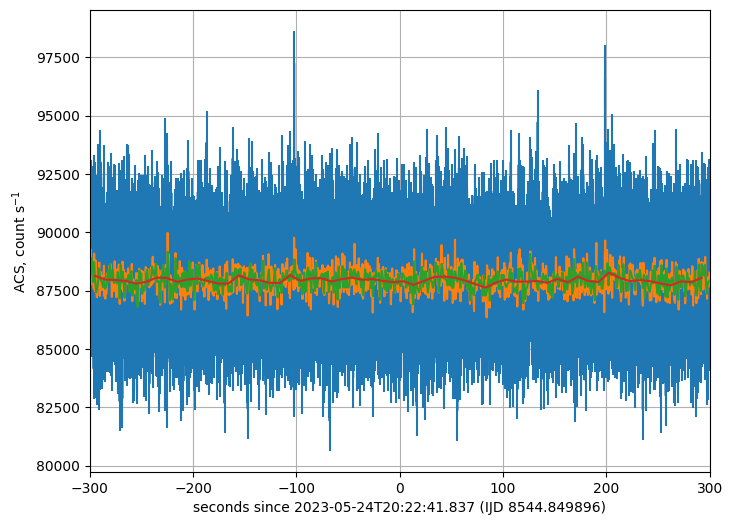

In [16]:
summary = dict()    

for n, lc in lcs.items():

    try:
        rel_s = (lc[:,0]-t0_ijd)*24*3600
    except:
        continue

    m = rel_s>-tstart_rel_mseconds
    m &= rel_s<tstop_rel_seconds

    print("total lc",lc.shape)
    print("min",lc[:,0].min()-t0_ijd)
    print("max",lc[:,0].max()-t0_ijd)

    lc = lc[m]

    b_tb = np.mean(lc[:,1])    

    rel_s = (lc[:,0]-t0_ijd)*24*3600

    expected_telapse = tstop_rel_seconds + tstop_rel_seconds    

    if len(rel_s) == 0:
        telapse = 0
        ontime = 0
    else:
        telapse = rel_s.max() - rel_s.min()
        ontime = np.sum(lc[:,1])


    print("expected telapse", expected_telapse, "telapse", telapse, "ontime", ontime)

    if float(ontime) / expected_telapse < required_completeness:
        raise Exception("data not available: exected %.5lg elapsed %.5lg ontime %.5lg completeness %s requireed %s"%(
            expected_telapse, telapse, ontime,
            ontime / expected_telapse, required_completeness))

    lc_summary = dict()
    summary[n.replace("/","_")]=lc_summary

    print("size", lc.shape, rel_s.shape)

    if np.sum(m) == 0: continue

    pylab.figure(figsize=(8,6))


    for ascale in [0.05, 0.5, 1, 10]:
        summary_scale = dict()
        lc_summary[('s_%.5lg'%ascale).replace(".","_")] = summary_scale        


        print("requested scale",ascale)
        print("b_tb",b_tb)

        if b_tb>ascale:
            ascale = b_tb


        nscale = int(ascale/b_tb)
        scale=nscale*b_tb

        print("acceptable, will be", nscale, scale)

        rate = rebin(lc[:,2],nscale,False)/scale
        rate_err = rebin(lc[:,2],nscale,False)**0.5/scale

        print("rebinned to",rate.shape)

        pylab.errorbar(
            rebin(rel_s,nscale,True),
            rate,
            rate_err,
            xerr=scale/4.
        )

        summary_scale['meanrate'] = np.mean(rate)
        summary_scale['maxrate'] = np.max(rate)
        summary_scale['stdvar'] = np.std(rate)
        summary_scale['meanerr'] = np.mean(rate_err**2)**0.5
        summary_scale['excvar'] = summary_scale['stdvar']/summary_scale['meanerr']        

        summary_scale['maxsnr'] = np.max((rate-np.mean(rate))/rate_err/summary_scale['excvar'])

        summary_scale['localfar'] = stats.norm.sf(summary_scale['maxsnr'])*rate.shape[0]

        summary_scale['localfar_s'] = stats.norm.isf(summary_scale['localfar']/2.) if summary_scale['localfar']<1 else 0

        # add FAR spike here

        if 'best' not in lc_summary or summary_scale['localfar_s'] > lc_summary['best']['localfar_s']:
            lc_summary['best'] = dict(
                localfar_s = summary_scale['localfar_s'],
                scale = ascale,
            )

        print(summary_scale)


    #tight_layout()
    pylab.grid()

    pylab.xlim(-tstart_rel_mseconds, tstop_rel_seconds)
    #pylab.axhspan(0,10,alpha=0.2,color="red")
    #pylab.axhspan(10,15,alpha=0.2,color="green")
    #pylab.axhspan(15,20,alpha=0.2,color="blue")
    pylab.ylabel(n+", count s$^{-1}$")
    #ylim([0,50])
    pylab.xlabel("seconds since %s (IJD %.10lg)"%(t0_utc, t0_ijd))

    fn=n.replace("/","_") + "_lc.png"
    pylab.savefig(fn)
    print("saving as",fn)
    break


In [17]:
# below S/N of 4 FAR is determined primarily by poisson, above - by spikes

def approx_FAR_spike_hz(snr, scale):    
    lim_snr = 2
    
    spike_rate_snr6 = 60./3600./24.
    if scale>=0.1:
        spike_rate_snr6*=(scale/0.1)**-1
    
    
    approx_FAR_hz = snr*0 + spike_rate_snr6 * (lim_snr/6.)**-2.7 
    
    try:
        if snr>lim_snr:
            approx_FAR_hz = spike_rate_snr6 * (np.abs(snr)/6.)**-2.7
    except:
        m=snr>lim_snr
        approx_FAR_hz[m] = (np.abs(snr[m])/6.)**-2.7 * spike_rate_snr6
        

    return approx_FAR_hz

def approx_FAR_norm_hz(snr, scale_s):
    return stats.norm.sf(snr)/scale_s

def approx_FAP(snr, t, scale_s):
    
    try:
        t_scaled = t[:]
        t_scaled[abs(t)<scale_s]=scale_s
    except:
        if abs(t)<scale_s:
            t_scaled=scale_s
        else:
            t_scaled=t

    approx_FAP = 2 * ( approx_FAR_norm_hz(snr, scale_s) + approx_FAR_spike_hz(snr, scale_s) )  * abs(t_scaled) * (1+np.log( 30/0.1))
    
    return approx_FAP



(1e-05, 30)

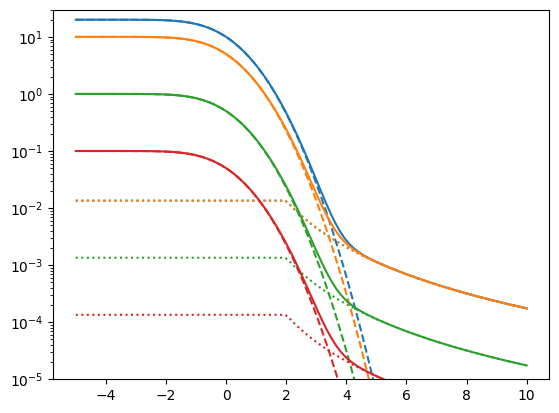

In [18]:
pylab.figure()

x=np.linspace(-5,10,100)

for scale_s in 0.05, 0.1, 1, 10:

    c=pylab.plot(x,approx_FAR_norm_hz(x, scale_s), ls='--')
    pylab.plot(x,approx_FAR_spike_hz(x, scale_s),c=c[0].get_color(),ls=":")
    pylab.plot(x,
               approx_FAR_spike_hz(x, scale_s) + approx_FAR_norm_hz(x, scale_s),
               c=c[0].get_color()
              )


    pylab.semilogy()

pylab.ylim([1e-5, 30])


In [19]:
timescales = sorted(set([0.05*ns for ns in sorted(set(
    list(map(int,np.logspace(0,np.log10(20*30),100))) 
))]  + list(np.linspace(1,31,30*2+1))))
timescales

[0.05,
 0.1,
 0.15000000000000002,
 0.2,
 0.25,
 0.30000000000000004,
 0.35000000000000003,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6000000000000001,
 0.65,
 0.7000000000000001,
 0.75,
 0.8,
 0.8500000000000001,
 0.9,
 0.9500000000000001,
 1.0,
 1.1,
 1.1500000000000001,
 1.25,
 1.3,
 1.4000000000000001,
 1.5,
 1.6,
 1.7000000000000002,
 1.85,
 1.9500000000000002,
 2.0,
 2.1,
 2.25,
 2.4000000000000004,
 2.5,
 2.5500000000000003,
 2.7,
 2.9000000000000004,
 3.0,
 3.1,
 3.3000000000000003,
 3.5,
 3.5500000000000003,
 3.75,
 4.0,
 4.3,
 4.5,
 4.6000000000000005,
 4.9,
 5.0,
 5.2,
 5.5,
 5.550000000000001,
 5.95,
 6.0,
 6.3500000000000005,
 6.5,
 6.75,
 7.0,
 7.2,
 7.5,
 7.7,
 8.0,
 8.200000000000001,
 8.5,
 8.75,
 9.0,
 9.35,
 9.5,
 10.0,
 10.5,
 10.65,
 11.0,
 11.350000000000001,
 11.5,
 12.0,
 12.100000000000001,
 12.5,
 12.950000000000001,
 13.0,
 13.5,
 13.8,
 14.0,
 14.5,
 14.700000000000001,
 15.0,
 15.5,
 15.700000000000001,
 16.0,
 16.5,
 16.75,
 17.0,
 17.5,
 17.85,
 18.0,
 18.5,
 19.0,
 1

total lc (12000, 3)
min -0.003471874999377178
max 0.0034719953710009577
expected telapse 600.0 telapse 599.9504000006709 ontime 600.0000000000001
size (12000, 3) (12000,)
requested scale 0.05
true scale 0.05000000000000001
offset 0 rebinned to (12000,)
summary_scale['excvar'] 1.1727771490695365
3955 5.687460412305301 -102.21989997080527
scale 0.05000000000000001 offset 0 found excesses 22
requested scale 0.1
true scale 0.10000000000000002
offset 0 rebinned to (6000,)
summary_scale['excvar'] 1.1721370526269572
1977 4.478093119555338 -102.24490007094573
scale 0.10000000000000002 offset 0 found excesses 11
offset 1 rebinned to (5999,)
summary_scale['excvar'] 1.1721951097752785
1977 5.673616949576648 -102.19489994924515
scale 0.10000000000000002 offset 1 found excesses 10
requested scale 0.15000000000000002
true scale 0.15000000000000002
offset 0 rebinned to (4000,)
summary_scale['excvar'] 1.1833707103835174
1318 4.930057405317207 -102.21990002319217
scale 0.15000000000000002 offset 0 foun

{'localfar_s': 4.096540132248354,
 'scale': 0.1,
 'summary_scale': {'scale_s': 0.10000000000000002,
  'meanrate': 87938.31305217535,
  'maxrate': 94399.99999999999,
  'stdvar': 1099.231006726533,
  'meanerr': 937.7543017879221,
  'excvar': 1.1721951097752785,
  'maxsnr': 5.673616949576648,
  'maxsnr_t': -102.19489994924515,
  'localfar': 4.1937081371743716e-05,
  'localfar_s': 4.096540132248354,
  'excesses': [{'snr': 3.106484605021016,
    'rel_s_scale': -298.9950000483077,
    'rate': 91419.99999999999,
    'rate_err': 956.1380653441216,
    'rate_overbkg': 3481.686947824637,
    'FAP': 54.41239383140385},
   {'snr': 3.2464026541544073,
    'rel_s_scale': -268.2949999754783,
    'rate': 91579.99999999999,
    'rate_err': 956.9743988216193,
    'rate_overbkg': 3641.686947824637,
    'FAP': 34.13736995516738},
   {'snr': 3.1764739092495553,
    'rel_s_scale': -186.99500003422145,
    'rate': 91499.99999999999,
    'rate_err': 956.5563234854494,
    'rate_overbkg': 3561.686947824637,
  

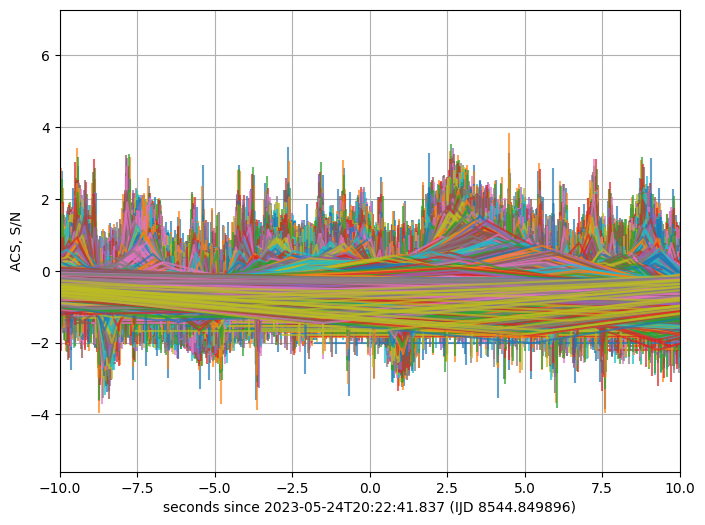

In [20]:
summary = dict()    
all_excesses=[]            

best_lc=None

for n, lc in lcs.items():
    
    #rel_s = lc[:,0]
    rel_s = (lc[:,0]-t0_ijd)*24*3600
    

    m = rel_s>-tstart_rel_mseconds
    m &= rel_s<tstop_rel_seconds
    
    print("total lc",lc.shape)
    print("min",lc[:,0].min()-t0_ijd)
    print("max",lc[:,0].max()-t0_ijd)
    
    lc = lc[m]
   # rel_s = lc[:,0]
    
    b_tb = np.mean(lc[:,1])    
    
    rel_s = (lc[:,0]-t0_ijd)*24*3600
    
    expected_telapse = tstop_rel_seconds + tstop_rel_seconds    
    
    if len(rel_s) == 0:
        telapse = 0
        ontime = 0
    else:
        telapse = rel_s.max() - rel_s.min()
        ontime = np.sum(lc[:,1])
        
    
    print("expected telapse", expected_telapse, "telapse", telapse, "ontime", ontime)
    
    if ontime / expected_telapse < required_completeness:
        raise Exception("data not available: exected %.5lg elapsed %.5lg ontime %.5lg"%(expected_telapse, telapse, ontime))
        
    lc_summary = dict()
    summary[n.replace("/","_")]=lc_summary
    
    print("size", lc.shape, rel_s.shape)
    
    if np.sum(m) == 0: continue
    
    pylab.figure(figsize=(8,6))
    
    best_lc_byscale={}

        
    
    #for ascale in [0.05, 0.1, 0.2, 0.5, 1, 2, 10]:
    for ascale in timescales:
    # for ascale in [0.05, 0.1, 0.5]:
    #for ascale in [0.05*i for i in range(20)] + [0.5*i for i in range(20)] + [15, 20, 25, 30]:
    #for ascale in [0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 1, 2, 8, 10]:
    #for ascale in [1,]:
        s_scale_mo = {}
        lc_summary[('s_%.5lg'%ascale).replace(".","_")] = s_scale_mo    
        
        
        print("requested scale",ascale)
#        print("b_tb",b_tb)
        
        if b_tb>ascale:
            ascale = b_tb
                    
        
        nscale = int(round(ascale/b_tb))
        scale=nscale*b_tb

        print("true scale", scale)
        
#        print("acceptable, will be", nscale, scale)
        
        c=None
        
        
        #for offset in range(0,nscale):            
        #for offset in (, round(nscale/2)):            
        
        if nscale < 20:
            offsets = range(0, round(nscale/2)+1)
        else:
            offsets = range(0, round(nscale/2)+1, max(round(round(nscale/2)/20), 1))
        
        for offset in offsets: 
            summary_scale = dict()
            s_scale_mo[offset]=summary_scale
            
            rel_s_scale = rebin(rel_s[offset:], nscale, True)
            rate = rebin(lc[offset:,2],nscale,False)/scale        
            rate_err = rebin(lc[offset:,2],nscale,False)**0.5/scale

            #print("rebinned to",rate.shape)
            print("offset", offset, "rebinned to",rate.shape)
            
            
            summary_scale['scale_s']=scale
            summary_scale['meanrate'] = np.mean(rate)
            summary_scale['maxrate'] = np.max(rate)            
            summary_scale['stdvar'] = np.std(rate)
            summary_scale['meanerr'] = np.mean(rate_err**2)**0.5
            summary_scale['excvar'] = summary_scale['stdvar']/summary_scale['meanerr']        

            print("summary_scale['excvar']", summary_scale['excvar'])

            if negative_excesses==1:
                snr = -(rate-np.mean(rate))/rate_err/summary_scale['excvar']
            else:
                snr = (rate-np.mean(rate))/rate_err/summary_scale['excvar']
            
            i_max = np.argmax(snr)
            
            print(i_max,snr[i_max],rel_s_scale[i_max])
            
            summary_scale['maxsnr'] = snr[i_max]
            summary_scale['maxsnr_t'] = rel_s_scale[i_max]

            summary_scale['localfar'] = stats.norm.sf(summary_scale['maxsnr'])*rate.shape[0]

            summary_scale['localfar_s'] = stats.norm.isf(summary_scale['localfar']/2.) if summary_scale['localfar']<1 else 0
            
            m_over_threshold = snr > global_snr_threshold
                        
            excesses = dict(
                            snr = snr[m_over_threshold],
                            rel_s_scale = rel_s_scale[m_over_threshold],
                            rate = rate[m_over_threshold],
                            rate_err = rate_err[m_over_threshold],
                            rate_overbkg = rate[m_over_threshold] - np.mean(rate),
                        )
                        
            summary_scale['excesses'] = [dict(zip(excesses.keys(), er)) for er in zip(*excesses.values())]

            for e in summary_scale['excesses']:
                e['FAP'] = approx_FAP(e['snr'], e['rel_s_scale'], scale)
            
            all_excesses+=[
                        dict(scale=scale, offset=offset,excess=e) for e in summary_scale['excesses']
                    ]

            print("scale", scale, "offset", offset, "found excesses",len(summary_scale['excesses']))                        

            #r=pylab.errorbar(
            #    rebin(rel_s[offset:],nscale,True),
            #    rate,
            #    rate_err,
            #    xerr=scale/4.,
            #    c=c,
            #    alpha=0.7
            #)
            
        #    print(rel_s_scale.shape, snr.shape)
            
            r = pylab.errorbar(
                rel_s_scale,
                snr,
                snr*0+1,
                xerr=scale/4.,
                c=c,
                alpha=0.7
            )
            
            pylab.axvline(summary_scale['maxsnr_t'],c="k")
            
            
            c=r[0].get_color()

            
            # add FAR spike here

            if 'best' not in lc_summary or summary_scale['localfar_s'] > lc_summary['best']['localfar_s']:
                lc_summary['best'] = dict(
                    localfar_s = summary_scale['localfar_s'],
                    scale = ascale,
                    summary_scale = summary_scale,
                )
                best_lc=rel_s_scale,rate,rate_err
            
            if 'best' not in s_scale_mo or summary_scale['localfar_s'] > s_scale_mo['best']['localfar_s']:
                s_scale_mo['best'] = dict(
                    localfar_s = summary_scale['localfar_s'],
                    scale = ascale,
                    summary_scale = summary_scale,
                )
              #  best_lc=rel_s_scale,rate,rate_err
            
            if ascale not in best_lc_byscale or summary_scale['localfar_s'] > best_lc_byscale[ascale]['localfar_s']:
                best_lc_byscale[ascale] = dict(
                    localfar_s = summary_scale['localfar_s'],
                    scale = ascale,
                    summary_scale = summary_scale,
                    best_lc=(rel_s_scale,rate,rate_err),
                )
                
        
            #print(summary_scale)
        s_scale_mo.update(s_scale_mo['best']['summary_scale'])

    #tight_layout()
    pylab.grid()

    #pylab.xlim(-tstart_rel_mseconds, tstop_rel_seconds)
    #pylab.axhspan(0,10,alpha=0.2,color="red")
    #pylab.axhspan(10,15,alpha=0.2,color="green")
    #pylab.axhspan(15,20,alpha=0.2,color="blue")
    pylab.ylabel(n+", S/N")
    #ylim([0,50])
    pylab.xlabel("seconds since %s (IJD %.10lg)"%(t0_utc, t0_ijd))
    pylab.xlim([-10, 10])
    
    detfn=n.replace("/","_") + "_det_lc.png"
    pylab.savefig(detfn)
    print("saving as",detfn)
    
summary['ACS']['best']

(-200.0, 200.0)

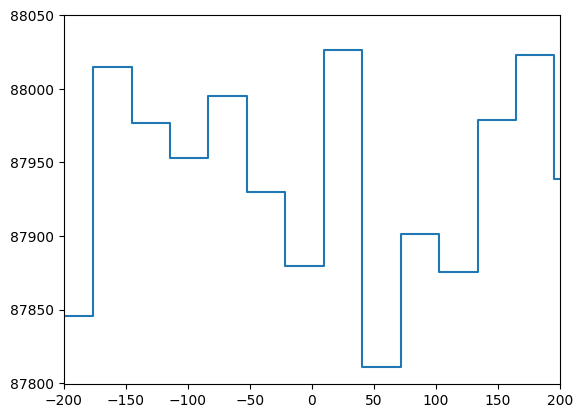

In [21]:
plt.figure()


snr = (rate-np.mean(rate))/rate_err/summary_scale['excvar']

plt.step(
    rel_s_scale,
    rate
)
plt.xlim(-200,200)
            

In [22]:
for e in all_excesses:
    if np.abs(e['scale'] - 0.05)< 0.001:
        # if np.abs(e['excess']['rel_s_scale']) < 5:
        print(e['excess']['rel_s_scale'], e)

-289.6199999784585 {'scale': 0.05000000000000001, 'offset': 0, 'excess': {'snr': 3.164761755752553, 'rel_s_scale': -289.6199999784585, 'rate': 92999.99999999999, 'rate_err': 1363.8181696985853, 'rate_overbkg': 5061.893333333341, 'FAP': 75.43670854369996}}
-226.8699997686781 {'scale': 0.05000000000000001, 'offset': 0, 'excess': {'snr': 3.480156632607796, 'rel_s_scale': -226.8699997686781, 'rate': 93519.99999999999, 'rate_err': 1367.6256797823005, 'rate_overbkg': 5581.893333333341, 'FAP': 24.43593703553331}}
-224.77000000071712 {'scale': 0.05000000000000001, 'offset': 0, 'excess': {'snr': 3.091731499422824, 'rel_s_scale': -224.77000000071712, 'rate': 92879.99999999999, 'rate_err': 1362.9380029920653, 'rate_overbkg': 4941.893333333341, 'FAP': 72.50569806102305}}
-186.97000009124167 {'scale': 0.05000000000000001, 'offset': 0, 'excess': {'snr': 3.6733885108635547, 'rel_s_scale': -186.97000009124167, 'rate': 93839.99999999999, 'rate_err': 1369.9635031634964, 'rate_overbkg': 5901.893333333341

In [23]:
grouped_excesses = []

for i in sorted(all_excesses, key=lambda x:x['excess']['FAP']):
    if i['excess']['FAP']<1 or True:
        print(i['scale'],i['offset'], i['excess']['snr'], i['excess']['rel_s_scale'], i['excess']['FAP'])
        
        grouped=False
        for g in grouped_excesses:
            if abs(i['excess']['rel_s_scale']-g['excess']['rel_s_scale'])<max(i['scale'],g['scale']):
                print("to group", g['excess']['rel_s_scale'])
                if i['excess']['snr'] > g['excess']['snr']:
                    print("group takeover")
                    g.update(i)
                grouped=True
                
        if not grouped:
            print("new group")
            #i['group']=[i]
            grouped_excesses.append(i)
        
    

11.500000000000002 72 3.4089316169157735 203.85530787105066 0.15345554480179582
new group
20.350000000000005 190 3.079725006396179 208.08032657852436 0.19965731813283405
to group 203.85530787105066
14.500000000000004 105 3.185028413695255 205.50531521610162 0.2104723649055256
to group 203.85530787105066
11.000000000000002 66 3.2084298522112915 203.80530732017095 0.2592713772556949
to group 203.85530787105066
9.500000000000002 85 3.2298291191684663 203.00530478379713 0.2833633117157566
to group 203.85530787105066
11.500000000000002 66 3.149205869756112 203.5553070021358 0.2882012604655264
to group 203.85530787105066
13.800000000000002 28 3.0446172106801015 205.1053138139769 0.3185376460069293
to group 203.85530787105066
9.350000000000001 55 3.1839451041363036 202.9803043250667 0.32328314655095025
to group 203.85530787105066
9.350000000000001 50 3.182062483126738 202.73030378842068 0.32444104159371273
to group 203.85530787105066
11.500000000000002 78 3.0986893219699 204.1553091772822 0.3

In [24]:
grouped_excesses=sorted(grouped_excesses, key=lambda x:x['excess']['FAP'])

for i in grouped_excesses:
    print(f"timescale {i['scale']:4.2f}   S/N {i['excess']['snr']:5.2f}   T0+{i['excess']['rel_s_scale']:7.1f}   FAP {i['excess']['FAP']:7.5f}")

timescale 0.70   S/N  4.35   T0+ -224.6   FAP 0.73978
timescale 0.45   S/N  3.49   T0+   53.5   FAP 0.85716
timescale 0.65   S/N  3.20   T0+   40.3   FAP 0.87942
timescale 2.00   S/N  3.56   T0+ -298.0   FAP 0.94385
timescale 0.70   S/N  3.08   T0+   35.1   FAP 0.99011
timescale 0.05   S/N  5.69   T0+ -102.2   FAP 1.09982
timescale 0.70   S/N  3.23   T0+   59.7   FAP 1.12771
timescale 0.55   S/N  3.17   T0+  -43.7   FAP 1.22977
timescale 0.10   S/N  3.42   T0+  -21.1   FAP 1.77774
timescale 0.40   S/N  3.81   T0+  203.6   FAP 2.09276
timescale 0.20   S/N  3.82   T0+  107.4   FAP 2.17806
timescale 0.20   S/N  3.37   T0+  -48.0   FAP 2.25502
timescale 0.05   S/N  5.34   T0+  198.6   FAP 2.53950
timescale 0.45   S/N  3.29   T0+ -144.8   FAP 3.70410
timescale 0.05   S/N  4.20   T0+  133.5   FAP 3.72725
timescale 0.90   S/N  3.01   T0+  168.9   FAP 4.43253
timescale 0.20   S/N  3.14   T0+  -53.8   FAP 4.46267
timescale 0.20   S/N  3.46   T0+  116.1   FAP 4.48793
timescale 0.45   S/N  3.09  

In [25]:
import json

len(json.dumps(grouped_excesses))

10960

In [26]:
summary['ACS']['best']

{'localfar_s': 4.096540132248354,
 'scale': 0.1,
 'summary_scale': {'scale_s': 0.10000000000000002,
  'meanrate': 87938.31305217535,
  'maxrate': 94399.99999999999,
  'stdvar': 1099.231006726533,
  'meanerr': 937.7543017879221,
  'excvar': 1.1721951097752785,
  'maxsnr': 5.673616949576648,
  'maxsnr_t': -102.19489994924515,
  'localfar': 4.1937081371743716e-05,
  'localfar_s': 4.096540132248354,
  'excesses': [{'snr': 3.106484605021016,
    'rel_s_scale': -298.9950000483077,
    'rate': 91419.99999999999,
    'rate_err': 956.1380653441216,
    'rate_overbkg': 3481.686947824637,
    'FAP': 54.41239383140385},
   {'snr': 3.2464026541544073,
    'rel_s_scale': -268.2949999754783,
    'rate': 91579.99999999999,
    'rate_err': 956.9743988216193,
    'rate_overbkg': 3641.686947824637,
    'FAP': 34.13736995516738},
   {'snr': 3.1764739092495553,
    'rel_s_scale': -186.99500003422145,
    'rate': 91499.99999999999,
    'rate_err': 956.5563234854494,
    'rate_overbkg': 3561.686947824637,
  

In [27]:
#T

In [28]:
summary['ACS']['s_8']

{0: {'scale_s': 8.000000000000002,
  'meanrate': 87938.10666666666,
  'maxrate': 88230.49999999999,
  'stdvar': 127.3264974604876,
  'meanerr': 104.84399521829243,
  'excvar': 1.214437671851259,
  'maxsnr': 2.2925977353705114,
  'maxsnr_t': 200.00530003981112,
  'localfar': 0.8201690582718024,
  'localfar_s': 0.22732754197071461,
  'excesses': []},
 'best': {'localfar_s': 1.7689292440005457,
  'scale': 8.0,
  'summary_scale': {'scale_s': 8.000000000000002,
   'meanrate': 87934.49662162161,
   'maxrate': 88353.49999999999,
   'stdvar': 135.77107430143187,
   'meanerr': 104.84184316246399,
   'excvar': 1.2950084642354067,
   'maxsnr': 3.078775572044096,
   'maxsnr_t': 202.2053019213854,
   'localfar': 0.07690568318580299,
   'localfar_s': 1.7689292440005457,
   'excesses': [{'snr': 3.078775572044096,
     'rel_s_scale': 202.2053019213854,
     'rate': 88353.49999999999,
     'rate_err': 105.09132932835132,
     'rate_overbkg': 419.0033783783729,
     'FAP': 0.4947780017607754}]}},
 4: {'

In [29]:
excvar_summary=dict(
)

for k,s in summary['ACS'].items():
    if 'scale_s' in s:
        print("%.5lg"%s['scale_s'], "%5.4lg"%s['excvar'])
        
        if s['scale_s']<=0.200:
            kg='hf_200ms'
        elif s['scale_s']<=2.00:
            kg='mf_200ms_2s'
        elif s['scale_s']<=10.00:
            kg='mf_2s_10s'
        else:
            kg='lf_10s'
        
        if kg not in excvar_summary:
            excvar_summary[kg]=[s['excvar']]
        else:
            excvar_summary[kg]+=[s['excvar']]

for k,v in excvar_summary.items():
    print(k,min(v),max(v))

0.05 1.173
0.1 1.172
0.15 1.169
0.2 1.189
0.25 1.171
0.3 1.185
0.35 1.191
0.4 1.165
0.45 1.182
0.5 1.169
0.55 1.193
0.6 1.203
0.65 1.218
0.7 1.207
0.75 1.233
0.8 1.175
0.85  1.21
0.9 1.215
0.95   1.2
1 1.204
1.1 1.198
1.15 1.216
1.25 1.218
1.3 1.216
1.4 1.193
1.5 1.297
1.6 1.256
1.7 1.253
1.85  1.26
1.95 1.226
2 1.183
2.1 1.243
2.25 1.234
2.4 1.213
2.5  1.28
2.55 1.275
2.7 1.249
2.9 1.264
3 1.243
3.1 1.244
3.3 1.259
3.5 1.273
3.55 1.237
3.75 1.338
4 1.338
4.3 1.241
4.5 1.375
4.6 1.289
4.9 1.259
5 1.236
5.2 1.204
5.5 1.304
5.55 1.194
5.95 1.246
6 1.389
6.35   1.3
6.5 1.231
6.75 1.304
7 1.254
7.2  1.31
7.5  1.34
7.7 1.245
8 1.295
8.2 1.168
8.5 1.221
8.75 1.198
9  1.31
9.35 1.289
9.5 1.292
10 1.215
10.5 1.267
10.65 1.211
11 1.311
11.35 1.262
11.5   1.2
12 1.425
12.1 1.351
12.5 1.321
12.95 1.257
13 1.272
13.5 1.357
13.8 1.293
14 1.315
14.5 1.273
14.7 1.196
15 1.537
15.5  1.36
15.7 1.197
16 1.326
16.5 1.344
16.75 1.351
17 1.345
17.5 1.433
17.85 1.307
18 1.307
18.5 1.321
19 1.506
19.05  1.54

total lc (12000, 3)
min -0.003471874999377178
max 0.0034719953710009577
total lc (12000, 3)
min -0.003471874999377178
max 0.0034719953710009577
total lc (12000, 3)
min -0.003471874999377178
max 0.0034719953710009577
{'scale': 0.7000000000000002, 'offset': 2, 'excess': {'snr': 4.352612895781051, 'rel_s_scale': -224.64499997149687, 'rate': 89819.99999999997, 'rate_err': 358.2098347537176, 'rate_overbkg': 1882.103683947309, 'FAP': 0.7397774050577429}}
(-2.0, 2.0)
{'scale': 0.45000000000000007, 'offset': 1, 'excess': {'snr': 3.4935418914298495, 'rel_s_scale': 53.53020005277358, 'rate': 89782.2222222222, 'rate_err': 446.67219454843615, 'rate_overbkg': 1844.1010252562992, 'FAP': 0.8571637130302229}}
(-2.0, 2.0)
{'scale': 0.6500000000000001, 'offset': 1, 'excess': {'snr': 3.203380484186183, 'rel_s_scale': 40.33020004370393, 'rate': 89347.69230769228, 'rate_err': 370.7532712811587, 'rate_overbkg': 1409.5641303441953, 'FAP': 0.8794193214679453}}
good match 0.7000000000000002 0.6500000000000001


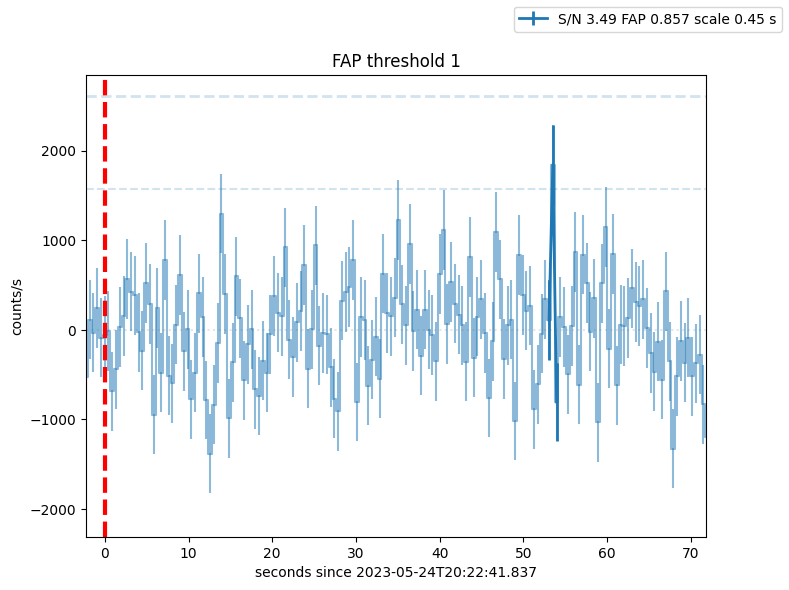

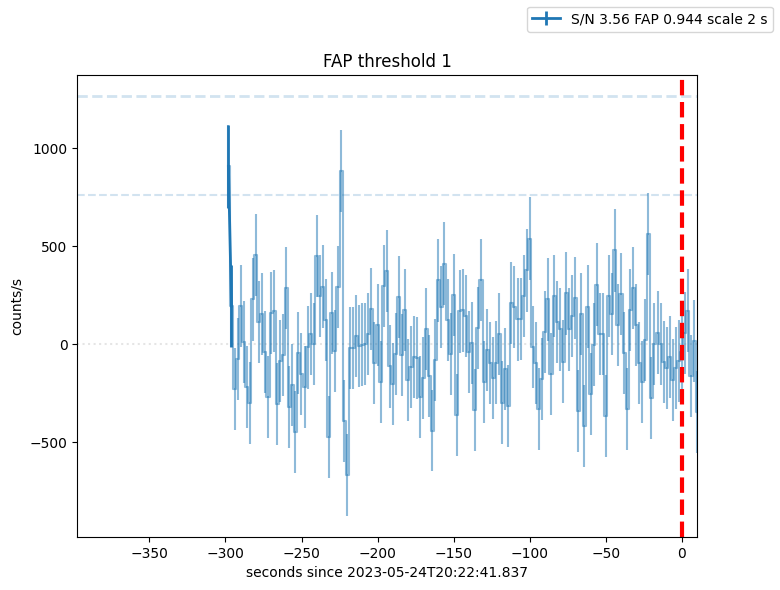

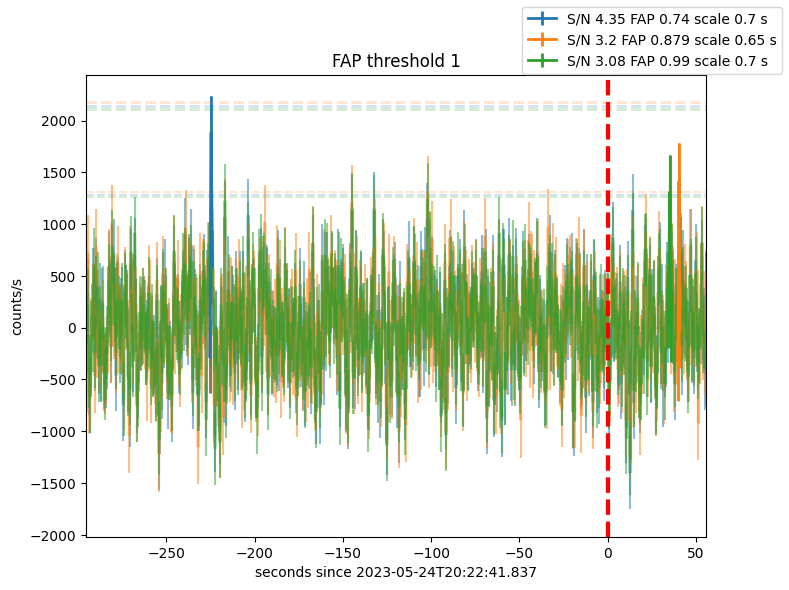

In [30]:
fig_names=[]


for limit_group in 0.02, 0.1, 1: 
    figs=dict()

    for n, lc in lcs.items():
        rel_s = (lc[:,0]-t0_ijd)*24*3600

        m = rel_s>-tstart_rel_mseconds
        m &= rel_s<tstop_rel_seconds

        print("total lc",lc.shape)
        print("min",lc[:,0].min()-t0_ijd)
        print("max",lc[:,0].max()-t0_ijd)

        lc = lc[m]
        rel_s = rel_s[m]

        for excess in grouped_excesses:
            #if excess['excess']['FAP'] > 0.02: continue
            if excess['excess']['FAP'] > limit_group: continue

            print(excess)


            offset = excess['offset']
            nscale = int(excess['scale']/b_tb)  
            scale=excess['scale']

            s_figs = sorted(figs.items(), key=lambda x:abs(x[0]-scale))

            if len(s_figs) == 0 or s_figs[0][0] < scale*0.5 or s_figs[0][0] > scale*1.5: 
                fig = pylab.figure(figsize=(8,6))
                figs[scale] = fig
                pylab.xlim([-2,2])
                pylab.xlabel("seconds since "+t0_utc)
                pylab.ylabel("counts/s")
                pylab.title("FAP threshold %.5lg"%limit_group)
            else:            
                print("good match", s_figs[0][0], scale)
                pylab.figure(s_figs[0][1].number)
                pylab.xlabel("seconds since "+t0_utc)
                pylab.ylabel("counts/s")



            rel_s_scale = rebin(rel_s[offset:],nscale,True)
            rate = rebin(lc[offset:,2],nscale,False)/scale        
            rate_err = rebin(lc[offset:,2],nscale,False)**0.5/scale

            bkg=np.mean(rate)

            m_on = np.abs(rel_s_scale-excess['excess']['rel_s_scale'])<excess['scale']*1.5


            pylab.grid(False)

            pylab.axhline(0, alpha=0.2, ls=":", color='gray')

            cr=pylab.errorbar(
                    rel_s_scale, 
                    (rate-bkg), 
                    (rate_err),
                    alpha=0.5,
                    ls="",
                )[0].get_color()

            pylab.step(
                    rel_s_scale, 
                    (rate-bkg), 
              #      (rate_err),
                    alpha=0.5,
                    where="mid",
                    c=cr,
                )

            pylab.axhline(np.std(rate)*3, alpha=0.2, ls="--",c=cr)
            pylab.axhline(np.std(rate)*5, alpha=0.2, ls="--", lw=2,c=cr)






            pylab.errorbar(
                    rel_s_scale[m_on], 
                    (rate-bkg)[m_on], 
                    (rate_err)[m_on],
                    lw=2.,
                    alpha=1,
                    label="S/N %.3lg FAP %.3lg scale %.3lg s"%(excess['excess']['snr'],excess['excess']['FAP'],excess['scale']),
                    c=cr
                )



            newlim=([
                min([excess['excess']['rel_s_scale']*1.3-excess['scale']*5,-excess['scale']*5]),
                max([excess['excess']['rel_s_scale']*1.3+excess['scale']*5,excess['scale']*5]),
            ])

            oldlim=pylab.gca().get_xlim()

            print(oldlim)

            pylab.xlim([
                min([oldlim[0],newlim[0]]),
                max([oldlim[1],newlim[1]]),
            ])


    for f_i,(s,f) in enumerate(figs.items()):
        f.legend()
        f.gca().axvline(0,ls="--",c="r",lw=3)
        fn="excess_%.5lg_%i.png"%(s,len(fig_names))
        f.savefig(fn)
        fig_names.append(fn)






axes [<Axes: > <Axes: > <Axes: >] <class 'numpy.ndarray'>


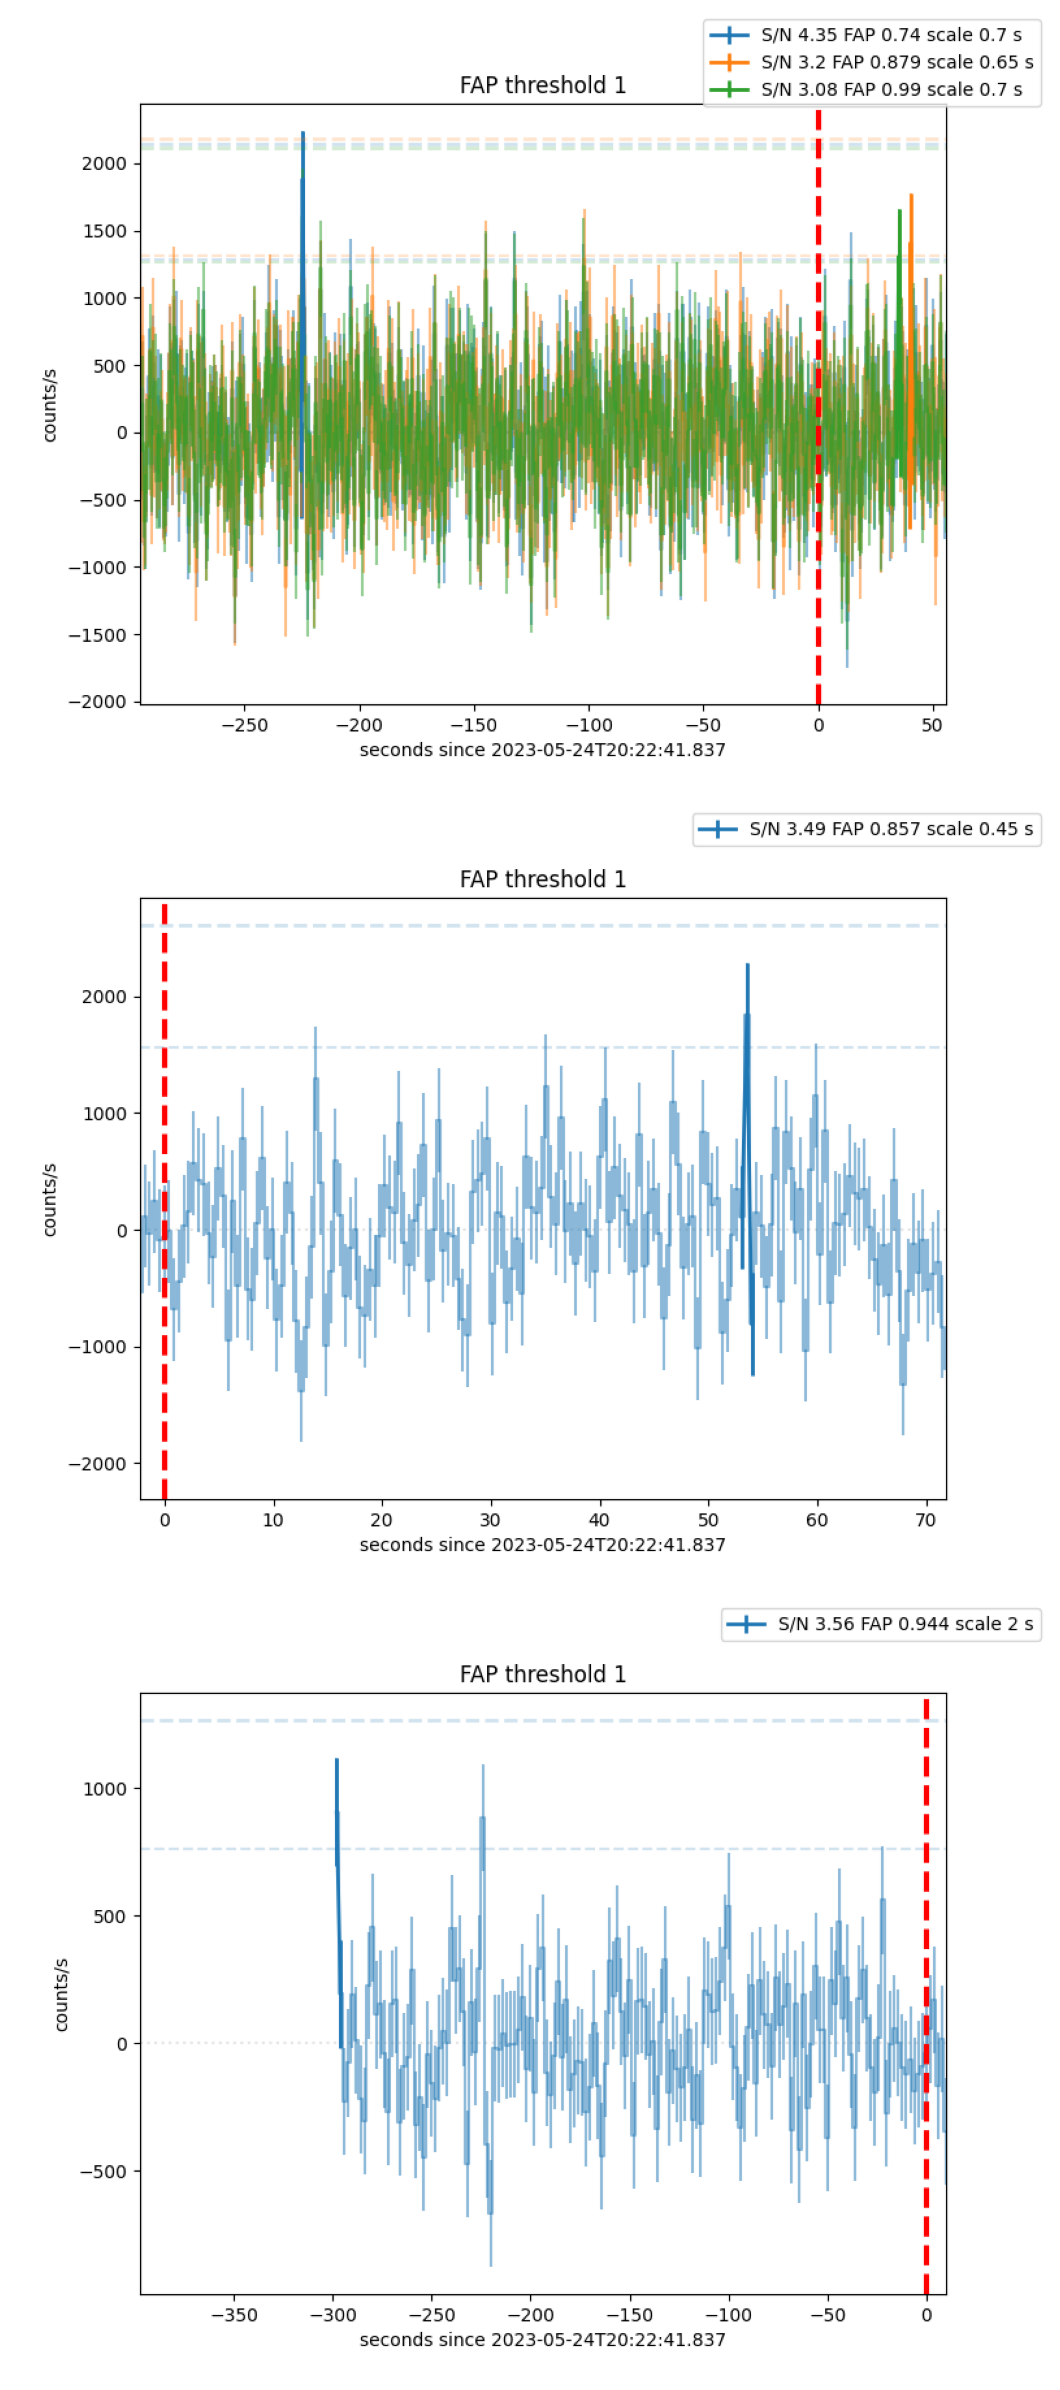

In [31]:
cols=1
rows=int(np.ceil(len(fig_names)/cols))


if rows>0:
    f, axes=pylab.subplots(rows, cols, figsize=(12, 8*rows))
    print("axes",axes,axes.__class__)

    if rows>1:
        axes=axes.flatten()
    else:
        axes=[axes]

    for i,fn in enumerate(fig_names):
        #f.add_subplot(len(fig_names), 2, i+1)
        axes[i].axis('off')
        axes[i].imshow(pylab.imread(fn) ) #, extent=(0,1,0,1))
        #pylab.imshow(pylab.imread(fn), extent=(0,1,(i-1)/len(fig_names),i/len(fig_names)))

    f.tight_layout()
else:
    f=pylab.figure()

f.savefig("excesses_mosaic.png")

In [32]:
if rt == 1:    
    summary['ACS_rt'] = summary['ACS']

In [33]:
summary['ACS']['s_1']['meanerr']

296.5435999421782

In [34]:
import json

json.dump(dict(
    summary=summary,
    reportable_excesses=grouped_excesses,
    excvar_summary=excvar_summary
), open("integral_all_sky.json","w"), indent=4)

In [35]:
acs_lc_png="ACS_lc.png"
acs_rt_lc_png="ACS_lc.png"
acs_rt_det_lc_png="ACS_det_lc.png"
ibis_veto_lc_png="IBIS_Veto_lc.png"
excesses_mosaic_png="excesses_mosaic.png"
summary=summary
reportable_excesses=grouped_excesses
excvar_summary=excvar_summary